In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

In [2]:
# Load Mnist Data
mnist = fetch_openml('mnist_784',version = 1, cache = True)
X = mnist.data
y = mnist.target

In [3]:
feature_cols = [f'pixel{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X.values,columns=feature_cols)
df['y'] = y # Label

In [4]:
#For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])    #0~69999의 수로 순서가 무작위인 배열을 생성한다.

# PCA 모델 생성
2차원까지 pca기법을 통해 차원축소를 하고, 그 결과를 각각 'pca-one'과 'pca-two'로 나누어 저장해두고 그것을 축으로 하여 시각화한다.

In [6]:
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(df[feature_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]

print("주성분 벡터가 이루는 축에 투영(projection)한 결과의 분산의 비율 : {}".format(pca.explained_variance_ratio_))

주성분 벡터가 이루는 축에 투영(projection)한 결과의 분산의 비율 : [0.09746116 0.07155445]


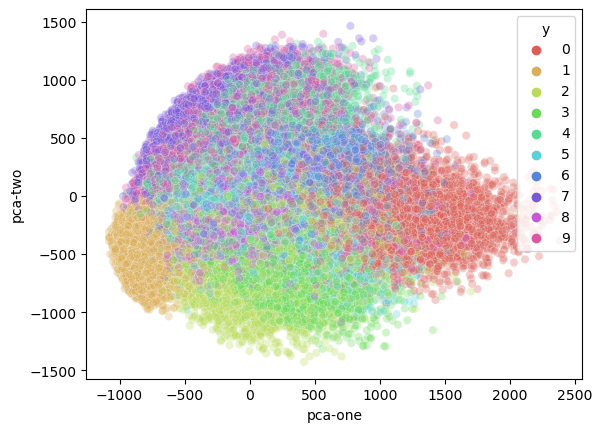

In [7]:
plt.figure()
sns.scatterplot(
    x = df['pca-one'] , y = df['pca-two'],
    hue = 'y',
    palette=sns.color_palette('hls',10),
    data = df.loc[rndperm,:],
    legend = 'full',
    alpha = 0.3
)
plt.show()


# t-SNE

In [8]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()    #rndperm배열의 index 0~9999까지 copy
data_subset = df_subset[feature_cols].values

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]
print("주성분 벡터가 이루는 축에 투영(projection)한 결과의 분산의 비율 : {}".format(pca.explained_variance_ratio_))

주성분 벡터가 이루는 축에 투영(projection)한 결과의 분산의 비율 : [0.09819946 0.07123677]


In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
tsne = TSNE(n_components=2,perplexity=40,n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

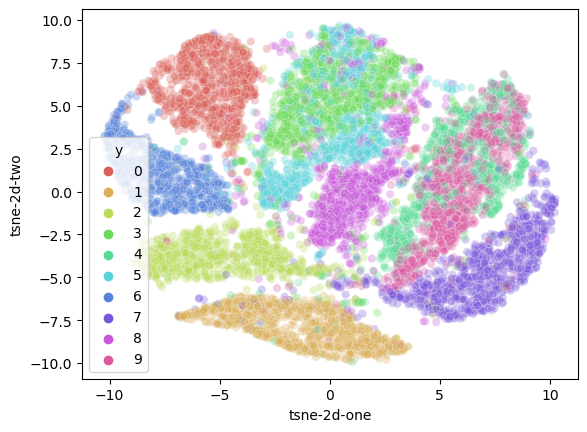

In [10]:
plt.figure()
sns.scatterplot(
    x = df_subset['tsne-2d-one'] , y = df_subset['tsne-2d-two'],
    hue = 'y',
    palette=sns.color_palette('hls',10),
    data = df.loc[rndperm,:],
    legend = 'full',
    alpha = 0.3
)
plt.show()

# ASSIGNMENT

In [11]:
import tensorflow as tf

## Split train and test data

In [12]:
X = (mnist.data.values/255).reshape(len(mnist.data),784)
y = tf.keras.utils.to_categorical(mnist.target.astype(int),10)

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=1)

## Setting Model

In [13]:
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model

Inputs = tf.keras.layers.Input(shape = (784,))
z1 = tf.keras.layers.Dense(512)(Inputs)
a1 = tf.keras.layers.Activation('relu')(z1)
z2 = tf.keras.layers.Dense(256)(a1)
a2 = tf.keras.layers.Activation('relu')(z2)
z3 = tf.keras.layers.Dense(128)(a2)
a3 = tf.keras.layers.Activation('relu')(z3)
z4 = tf.keras.layers.Dense(64)(a3)
a4 = tf.keras.layers.Activation('relu')(z4)
output = tf.keras.layers.Dense(10, activation = 'softmax')(a4)

model = tf.keras.models.Model(inputs = Inputs, outputs = output)

2022-11-23 19:07:06.501190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.compile(loss = "categorical_crossentropy", optimizer = 'sgd',metrics=['accuracy'])

In [16]:
model.fit(X_train,y_train,epochs =10,verbose=0)

In [17]:
model.evaluate(X_test,y_test)

657/657 [==============================] - 1s 1ms/step - loss: 0.0968 - accuracy: 0.9716


[0.09678259491920471, 0.9716190695762634]

## ndarray 형태로 나타나 있던 Label을 하나의 값들로 변환

In [18]:
label = []
for i,l in enumerate(y_train):
    label.append(int(np.where(l==1)[0]))

# 시각화

1
2
3
4


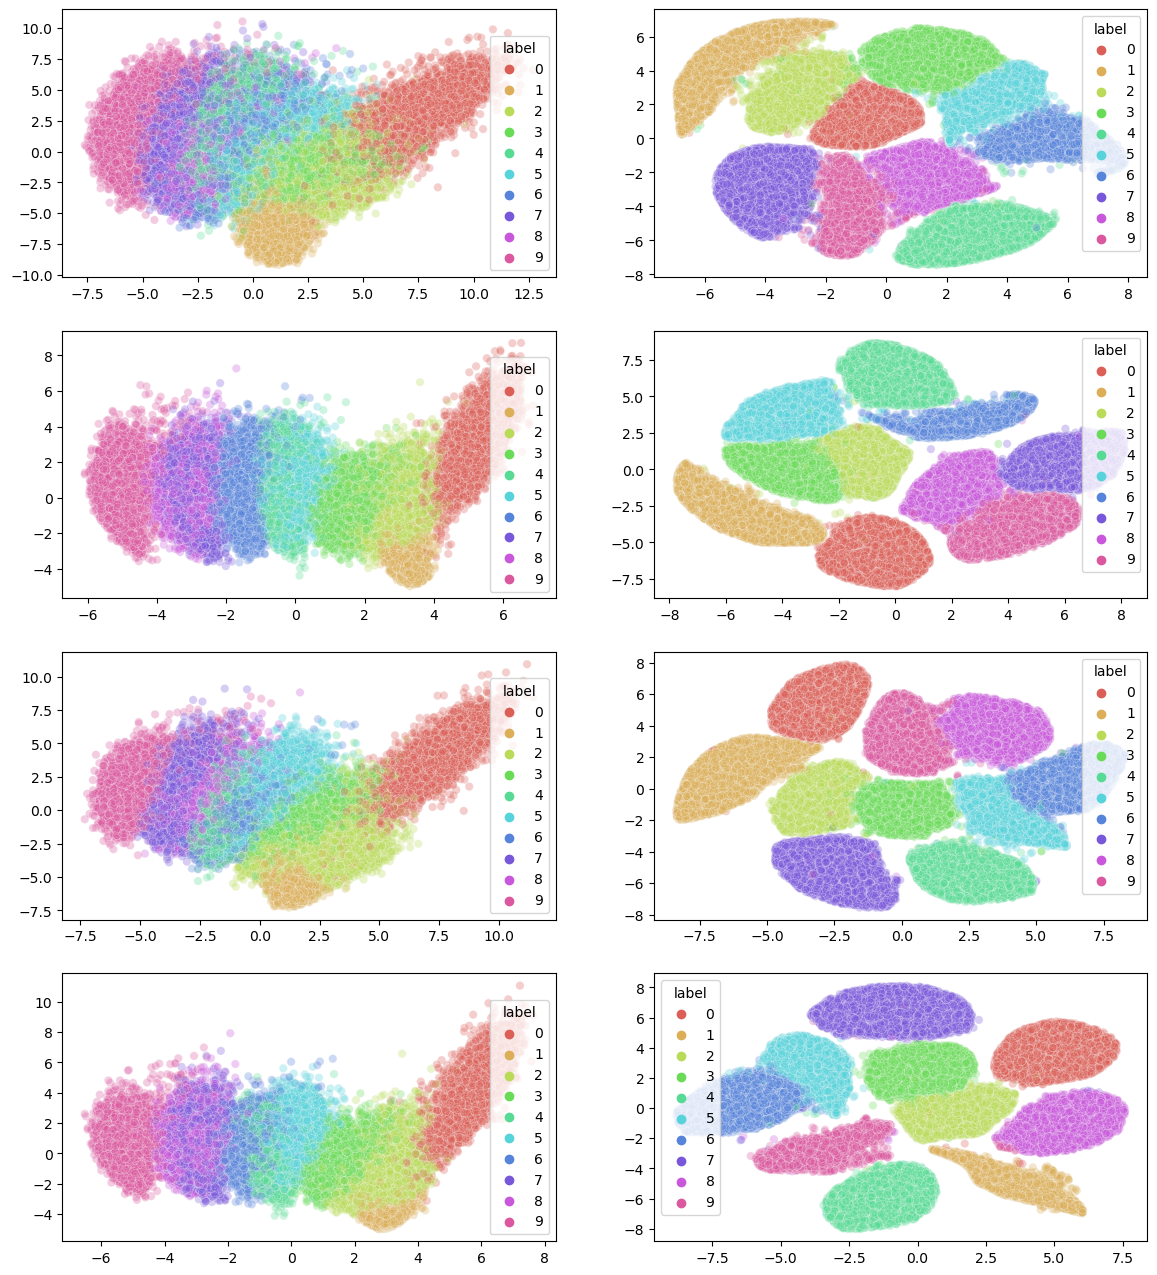

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

fig = plt.figure(figsize=(14,16))
for i in range(1,5):
    print(i)
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[i].output)
    intermediate_output = intermediate_layer_model(X_train)
    
    intermediate_output = pd.DataFrame(intermediate_output.numpy())
    intermediate_output["label"] = label

    pca = PCA(n_components = 2)
    pca_result = pca.fit_transform(intermediate_output)

    tsne = TSNE(n_components=2,verbose=0,perplexity=40,n_iter=300)
    tsne_result = tsne.fit_transform(intermediate_output)

    ax = fig.add_subplot(4,2,(i-1)*2+1)
    sns.scatterplot(
        x = pca_result[:,0] , y = pca_result[:,1],
        palette=sns.color_palette('hls',10),
        hue = 'label',
        data = intermediate_output,
        legend = 'full',
        alpha = 0.3,
        
        ax = ax,
    )
    ax = fig.add_subplot(4,2,(i-1)*2+2)
    sns.scatterplot(
        x = tsne_result[:,0] , y = tsne_result[:,1],
        palette=sns.color_palette('hls',10),
        hue = 'label',
        data = intermediate_output,
        legend = 'full',
        alpha = 0.3,

        ax = ax,
    )

plt.show()

# 결과분석
확실히 데이터 자체가 선형적이지 않다보니 성능면에서는 tSNE가 압도적으로 뛰어났다. 하지만, 실행해 보면 알 수 있듯이 속도면에서는 tSNE가 매우 느렸다. 따라서 무조건 tSNE만 사용하기 보다는 상황에 따라 선형적 데이터라면 PCA를 선택해 사용하는 것이 좋겠다.
